In [1]:
import pandas as pd
import sys
sys.path.insert(1, '/home/jason/esw/meter-anomaly-cron/py_src')
from python_lib.sliding_window import SlidingWindow
from python_lib.regressor import MLPRegressor, train_net
from torch import nn
import torch.optim as optim
import torch

/home/jason/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Foundry_STM_M23-MassFlow2.csv")
df['time'] //= 1000
# df['time'] = pd.to_datetime(df['time'],unit='s')
print(df.head())
print()
print(df.shape)
print()
print(df.dtypes)

        value        time
0  162.661850  1673395200
1  167.537910  1673398800
2  153.240338  1673402400
3  119.559933  1673406000
4  146.747250  1673409600

(517, 2)

value    float64
time       int64
dtype: object


<AxesSubplot: xlabel='time'>

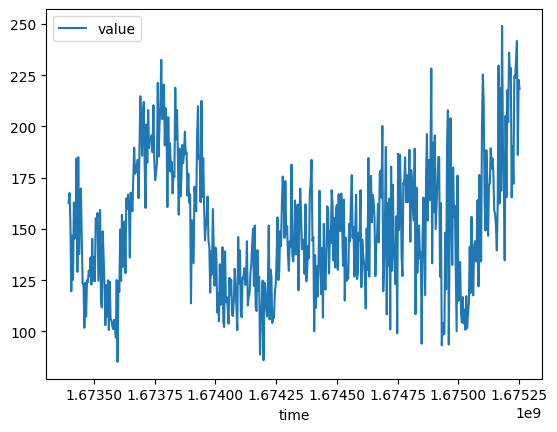

In [3]:
df.plot(x="time", y='value')

In [4]:
data = df.to_numpy().transpose()
time = data[1].copy()
data[1] = data[0]
data[0] = time
data

array([[1.67339520e+09, 1.67339880e+09, 1.67340240e+09, ...,
        1.67524560e+09, 1.67524920e+09, 1.67525280e+09],
       [1.62661850e+02, 1.67537910e+02, 1.53240338e+02, ...,
        1.86142300e+02, 2.22738875e+02, 2.18306200e+02]])

In [5]:
# k = 10
# knn = SlidingWindow(k, 0.9999)
# X, y = knn.generate_training_data(data[1].reshape((1, data.shape[1])))
# X = X.reshape((X.shape[0], X.shape[2]))
# y = y.reshape((y.shape[0], ))
# n = X.shape[0]
# X = torch.from_numpy(X).to(torch.float32).cuda()
# y = torch.from_numpy(y).to(torch.float32).cuda()

# net = MLPRegressor(k, [128, 128, 128, 128, 128])
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.09)
# lossfunc = nn.MSELoss()
# loss = train_net(net, optimizer, lossfunc, X, y, training_epochs=5000)

k = 25
knn = SlidingWindow(k)
train_size = 300
xTr, yTr = knn.generate_training_data(data[1].reshape((1, data.shape[1]))[:,:train_size])
xTr = xTr.reshape((xTr.shape[0], xTr.shape[2]))
yTr = yTr.reshape((yTr.shape[0], ))
n = xTr.shape[0]
print(f'n = {n}')
X = torch.from_numpy(xTr).to(torch.float32).cuda()
y = torch.from_numpy(yTr).to(torch.float32).cuda()

net = MLPRegressor(k, [32, 16, 8])
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
lossfunc = nn.MSELoss()
loss = train_net(net, optimizer, lossfunc, X, y, training_epochs=2000)
print(f'final loss: {loss}')

n = 274
using cuda


/home/jason/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([274])) that is different to the input size (torch.Size([274, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step 99 loss: 1638.258544921875
step 199 loss: 1629.5999755859375
step 299 loss: 1623.0643310546875
step 399 loss: 1618.1688232421875
step 499 loss: 1614.6199951171875
step 599 loss: 1612.0660400390625
step 699 loss: 1610.14990234375
step 799 loss: 1608.615234375
step 899 loss: 1607.3154296875
step 999 loss: 1606.17138671875
step 1099 loss: 1605.13623046875
step 1199 loss: 1604.178466796875
step 1299 loss: 1603.2763671875
step 1399 loss: 1602.4150390625
step 1499 loss: 1601.5819091796875
step 1599 loss: 1600.7701416015625
step 1699 loss: 1599.9736328125
step 1799 loss: 1599.188720703125
step 1899 loss: 1598.4117431640625
step 1999 loss: 1597.64111328125
final loss: 1597.6334228515625


In [6]:
import math
knn.attach_regressor(lambda x: net(torch.from_numpy(x).to(torch.float32).cuda()).cpu().detach().numpy(), math.sqrt(loss / n))

In [7]:
regressed_output, pci_upper, pci_lower, outlier = knn.slide_window(data[1].reshape((1, data.shape[1])), 0.99999)
pci_upper = pci_upper.flatten()
pci_lower = pci_lower.flatten()
regressed_output = regressed_output.flatten()
import numpy as np
train_error = np.sum(np.square(regressed_output[k:train_size] - data[1][k:train_size]))
test_error = np.sum(np.square(regressed_output[train_size:] - data[1][train_size:]))
print(train_error)
print(test_error)

134858.90425316987
187772.2626692907


16


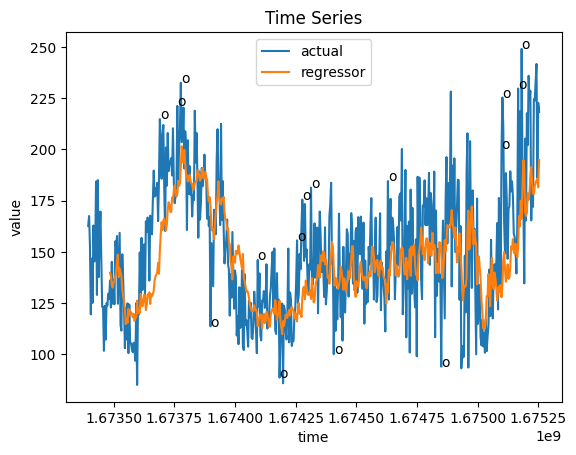

In [8]:
from matplotlib import pyplot as plt 

x = data[0]
y = data[1]
plt.title("Time Series") 
plt.xlabel("time") 
plt.ylabel("value") 
plt.plot(x,y, label="actual")
# plt.plot(x, pci_upper, label="upper")
# plt.plot(x, pci_lower, label="lower")
plt.plot(x, regressed_output, label="regressor")
for i in range(len(outlier)):
    if outlier[i]:
        plt.annotate('o', xy=(x[i], y[i]))
print(np.sum(outlier))
plt.legend()
plt.show()